In [1]:
# Support for math
import numpy as np
import math

# Plotting tools
from matplotlib import pyplot as plt
import matplotlib
from matplotlib import cm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
 
import warnings
warnings.filterwarnings('ignore')

# File Tools for local
import pandas as pd
import sys

# Random seed for reproducibility
import random

import torch
from botorch.utils.transforms import unnormalize, normalize

from ipywidgets import interact, FloatSlider

#LHS sampling
#from pyDOE import lhs

#from BOClass import Models, Plotting, PoolObjectives
from boclass_query import Models, Plotting, PoolObjectives

from tqdm.notebook import tqdm
from IPython.display import display

dtype = torch.float32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
all_data = pd.read_csv('../all_data.csv') # all_df = pd.concat([data01, data2A, data2B, data2C, data3A, data3B, data3C], axis=0, ignore_index=True)
data01 = all_data[:15]
data2A = all_data[15:30]
data2B = all_data[30:45]
data2C = all_data[45:60]
data3A = all_data[60:75]
data3B = all_data[75:90]
data3C = all_data[90:105]
# Model Sets
set_dataA = pd.concat([data01, data2A, data3A], axis=0, ignore_index=True)
set_dataB = pd.concat([data01, data2B, data3B], axis=0,ignore_index=True)
set_dataC = pd.concat([data01, data2C, data3C], axis=0,ignore_index=True)


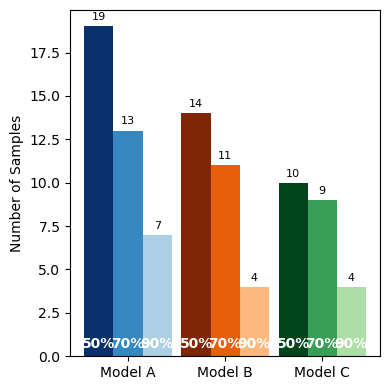

In [3]:
# Check Data
thresholds = [0.5, 0.7, 0.9]

# Calculate counts for each threshold for each model
counts_A = [ (set_dataA['yield product'] > thresh).sum().item() for thresh in thresholds ]
counts_B = [ (set_dataB['yield product'] > thresh).sum().item() for thresh in thresholds ]
counts_C = [ (set_dataC['yield product'] > thresh).sum().item() for thresh in thresholds ]

model_counts = [counts_A, counts_B, counts_C]
model_names = ['ModelA', 'ModelB', 'ModelC']  # Used for cm.*
num_bars_per_model = len(thresholds)

# Bar settings
bar_width = 0.3
x = np.arange(len(model_names))

# Colormap mapping
cmap_dict = {'ModelA': cm.Blues, 'ModelB': cm.Oranges, 'ModelC': cm.Greens}

# Create plot
fig, ax = plt.subplots(figsize=(4, 4))

# Plot each model group
for i, (model, counts) in enumerate(zip(model_names, model_counts)):
    cmap = cmap_dict[model]
    # Light to dark (0 = light, 1 = dark); reversed here for higher threshold to be lighter
    gradient_colors = [cmap(1 - j / num_bars_per_model) for j in range(num_bars_per_model)]
    
    for j, count in enumerate(counts):
        # j = threshold index (0: 0.5, 1: 0.7, 2: 0.9)
        xpos = x[i] + j * bar_width - bar_width  # Center group around x[i]
        rect = ax.bar(xpos, count, width=bar_width, color=gradient_colors[j],
                      label=f'{model} - {thresholds[j]:.1f}' if i == 0 else None)  # Only label once per threshold
        ax.bar_label(rect, padding=3, fontsize=8)

# Ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(['Model A', 'Model B', 'Model C'])
ax.set_ylabel('Number of Samples')

# Add annotations for thresholds
for i, model in enumerate(model_names):
    for j, count in enumerate(model_counts[i]):
        xpos = x[i] + j * bar_width - bar_width  # Center group around x[i]
        ax.text(xpos, 0.3, f'{thresholds[j]*100:.0f}%', ha='center', va='bottom', fontsize=10, fontweight = 'bold',color='white')

plt.tight_layout()
plt.show()


In [4]:
random_seed = 5
batch_size = 5
train_size = batch_size

# Iteration 0: Set up gp with initial data
original_bounds = torch.tensor([[30., 20., 75. , 33.], [600., 170., 100.,100.]], dtype=dtype, device=device)

x_inputs = all_data[['time','temp','sulf','anly'] ]
y_outputs = all_data["yield product"]
yvar_outputs = all_data["var yield"]
# Set the device and dtype
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32
# Convert to torch tensors
x_all = torch.tensor(x_inputs.to_numpy(), dtype=torch.float32)
nx_all = normalize(x_all,original_bounds)
y_all = torch.tensor(y_outputs.values.reshape(-1, 1), dtype=torch.float32)
yvar_all = torch.tensor(yvar_outputs.values.reshape(-1, 1), dtype=torch.float32)

random.seed(5)
random_indices = random.sample(range(x_all.shape[0]), train_size)
x_train = x_all[random_indices]
nx_train = normalize(x_train, bounds=original_bounds) # normalized data for training

y_train = y_all[random_indices]
y_train_var = yvar_all[random_indices]

# Remove x_train rows from x_inputs
# Convert x_train to numpy for comparison
x_train_np = x_train.cpu().numpy()
# Find all rows in x_inputs that are not in x_train
mask = ~x_inputs.apply(lambda row: ((x_train_np == row.values).all(axis=1)).any(), axis=1)
x_input_new = x_inputs[mask]
y_output_new = y_outputs[mask]
yvar_output_new = yvar_outputs[mask]
query = PoolObjectives(x_input_new, y_output_new ,yvar_output_new, columns=['time', 'temp', 'sulf', 'anly'])
# Step 1: Initialize your model
gp_model = Models(x_train=nx_train, y_train=y_train, y_train_var=y_train_var, bounds=original_bounds, batch_size=batch_size, objective=query)


# Set up a test set for evaluation
# Generate a 4D test_x grid within the normalized bounds [0, 1] for each dimension
num_points_per_dim = 20
grid_axes = [np.linspace(0, 1, num_points_per_dim) for _ in range(4)]
mesh = np.meshgrid(*grid_axes, indexing='ij')
test_x = np.stack([m.flatten() for m in mesh], axis=-1)
test_x = torch.tensor(test_x, dtype=torch.float32, device=device)




In [5]:
def BO_loop(gp_model,train_nx, train_y,train_yvar, x_all, y_all, yvar_all,iterations=5):
    store_model = []
    store_varsum = []
    query = PoolObjectives(x_all, y_all, yvar_all, columns=['time', 'temp', 'sulf', 'anly'])
    progress = tqdm(total=iterations, desc="BO Iterations", leave=True)  # put progress bar here
   
    for i in range(iterations):
        # Step 3: Get the next candidates
        
        # Remove new_candidates from x_all
        x_actual, y_actual, yvar_actual, used_id = gp_model.regular_candidates(x_all)
        #print(used_id)
        x_all = query.get_new_pool(used_id)

        nx_train = normalize(x_actual, bounds=original_bounds)
        #print(x_train.shape, y_train.shape, yvar_train.shape)
        # Combine the new data with the existing data
        train_nx = torch.cat((train_nx, nx_train), dim=0)
        train_y = torch.cat((train_y, y_actual), dim=0)
        train_yvar = torch.cat((train_yvar, yvar_actual), dim=0)
        #print(train_nx.shape, train_y.shape, train_yvar.shape)
        # Step 1: Instantiate and train model
        gp_model = Models(x_train=train_nx, y_train=train_y, y_train_var=train_yvar, bounds=original_bounds, batch_size=batch_size, objective=query, random_id = random_seed)

        _, var = gp_model.gp_evaluate(test_x, 'Regular')
        store_varsum.append(var.sum().item())
        store_model.append(gp_model)
        progress.update(1)  # Update progress bar after each iteration
    progress.close()  # Close the progress bar after completion
    return store_model, train_nx, train_y, store_varsum


In [8]:
# Reset 
x_inputs = all_data[['time','temp','sulf','anly'] ]
y_outputs = all_data["yield product"]
yvar_outputs = all_data["var yield"]

iterations = 45-train_size

gp_modelBO, train_nxBO, train_yBO, train_yvarBO = BO_loop(gp_model, nx_train, y_train, y_train_var, x_input_new, y_output_new ,yvar_output_new, iterations = iterations)

train_xBO = unnormalize(train_nxBO, original_bounds)
# Step 2: Initialize Plotting class
variable_combinations = [('time', 'sulf', 'anly'), ('theta', 'r', 't'), ('n', 't', 'theta')]
plotting = Plotting(gp_modelBO[0].model, variable_combinations=variable_combinations, select='Gaussian')
combination = variable_combinations[0]
minmax = [y_train.min(), y_train.max()]
# plotting.sliced_plotting(combination, minmax)


# argmax_indices = [data.argmax().item() for data in split_data]
# for i, idx in enumerate(argmax_indices):
#     print(f"Iteration {i + 1}: {split_datax[i][idx]}")



BO Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

In [10]:
# Compare BO, BBO batch size 3, BBO batch size 5, BBO batch size 15
seed = 0

def BBO_loop_batch(seed, gp_model, train_nx, train_y, train_yvar, x_all, y_all, yvar_all, batch_size, iterations=5):
    store_varsum = []
    query = PoolObjectives(x_all, y_all, yvar_all, columns=['time', 'temp', 'sulf', 'anly'])
    for i in range(iterations):
        new_candidates = gp_model.batch_candidates(batch_size=batch_size)
        x_actual, y_actual, yvar_actual, used_id = query.find_nearest(new_candidates)
        nx_train = normalize(x_actual, bounds=original_bounds)
        train_nx = torch.cat((train_nx, nx_train), dim=0)
        train_y = torch.cat((train_y, y_actual), dim=0)
        train_yvar = torch.cat((train_yvar, yvar_actual), dim=0)
        gp_model = Models(x_train=train_nx, y_train=train_y, y_train_var=train_yvar, bounds=original_bounds, batch_size=batch_size, objective=query, random_id= seed)
        _, var = gp_model.gp_evaluate(test_x, 'Regular')
        store_varsum.append(var.sum().item())
    return train_y, store_varsum

# Run BBO with different batch sizes
batch_sizes = [1, 3, 5, 15]
iterations_dict = {1: 45, 3: 15, 5: 9, 15: 3}  # To keep total points similar (3*15=5*9=15*3=45)
results = {}

for batch_size in batch_sizes:
    # Reset to initial train set
    train_nx_bbo = nx_train.clone()
    train_y_bbo = y_train.clone()
    train_yvar_bbo = y_train_var.clone()
    gp_model_bbo = Models(x_train=train_nx_bbo, y_train=train_y_bbo, y_train_var=train_yvar_bbo, bounds=original_bounds, batch_size=batch_size, objective=query, random_id= seed)
    y_bbo, varsum_bbo = BBO_loop_batch(seed, gp_model_bbo, train_nx_bbo, train_y_bbo, train_yvar_bbo, x_input_new, y_output_new, yvar_output_new, batch_size=batch_size, iterations=iterations_dict[batch_size])
    results[batch_size] = {'y_best': y_bbo,
                           'varsum': varsum_bbo}



In [78]:
results_store = []
for seed in range(10):  
  results = {}
  random.seed(seed)
  random_indices = random.sample(range(x_all.shape[0]), train_size)
  x_train = x_all[random_indices]
  nx_train = normalize(x_train, bounds=original_bounds) # normalized data for training

  y_train = y_all[random_indices]
  y_train_var = yvar_all[random_indices]
  
  for batch_size in batch_sizes:
    # Reset to initial train set
    train_nx_bbo = nx_train.clone()
    train_y_bbo = y_train.clone()
    train_yvar_bbo = y_train_var.clone()
    Models(x_train=train_nx_bbo, y_train=train_y_bbo, y_train_var=train_yvar_bbo, bounds=original_bounds, batch_size=batch_size, objective=query, random_id=seed)
    y_bbo, varsum_bbo = BBO_loop_batch(seed, gp_model_bbo, train_nx_bbo, train_y_bbo, train_yvar_bbo, x_input_new, y_output_new, yvar_output_new, batch_size=batch_size, iterations=iterations_dict[batch_size])
    results[batch_size] = {'y_best': y_bbo,
                          'varsum': varsum_bbo}
  results_store.append(results)


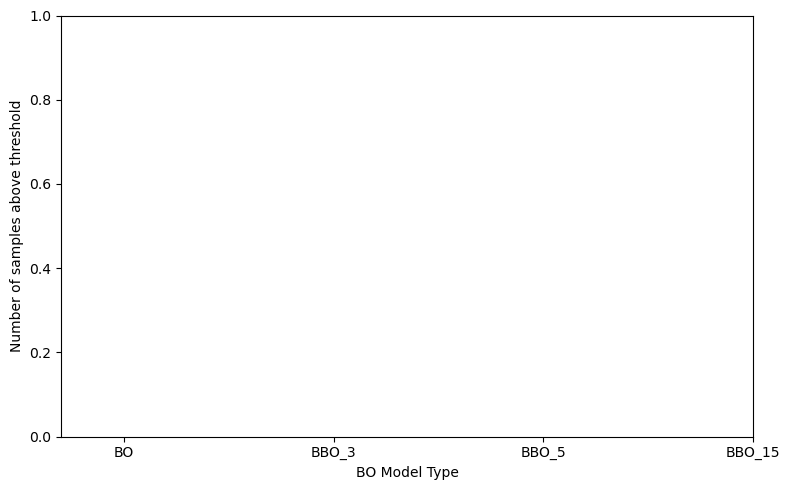

In [106]:
# Find indices where yield > 0.9 for each batch size
thresholds = [0.5, 0.7, 0.9]
idsBO_all = []
idsBBO_3_all = []
idsBBO_5_all = []
idsBBO_15_all = []
# Store the number of samples above each threshold for each run and batch size
idsBO_all = {thresh: [] for thresh in thresholds}
idsBBO_3_all = {thresh: [] for thresh in thresholds}
idsBBO_5_all = {thresh: [] for thresh in thresholds}
idsBBO_15_all = {thresh: [] for thresh in thresholds}

for result in results_store:
    for thresh in thresholds:
        idsBO = len((result[1]['y_best'] > thresh).nonzero(as_tuple=True)[0].tolist())
        idsBBO_3 = len((result[3]['y_best'] > thresh).nonzero(as_tuple=True)[0].tolist())
        idsBBO_5 = len((result[5]['y_best'] > thresh).nonzero(as_tuple=True)[0].tolist())
        idsBBO_15 = len((result[15]['y_best'] > thresh).nonzero(as_tuple=True)[0].tolist())
        idsBO_all[thresh].append(idsBO)
        idsBBO_3_all[thresh].append(idsBBO_3)
        idsBBO_5_all[thresh].append(idsBBO_5)
        idsBBO_15_all[thresh].append(idsBBO_15)

# Convert lists to numpy arrays for easier stats
for d in [idsBO_all, idsBBO_3_all, idsBBO_5_all, idsBBO_15_all]:
    for thresh in thresholds:
        d[thresh] = np.array(d[thresh])

# Plot the number of samples above each threshold for each method

labels = ['BO', 'BBO_3', 'BBO_5', 'BBO_15']
cmap_dict = {'BO': cm.Reds, 'BBO_3': cm.Blues, 'BBO_5': cm.Oranges, 'BBO_15': cm.Greens}


fig, ax = plt.subplots(figsize=(8, 5))
bar_width = 0.3
x = np.arange(len(labels))

for i, thresh in enumerate(thresholds):
    means = [
        idsBO_all[thresh].mean(),
        idsBBO_3_all[thresh].mean(),
        idsBBO_5_all[thresh].mean(),
        idsBBO_15_all[thresh].mean()
    ]
    stds = [
        idsBO_all[thresh].std(),
        idsBBO_3_all[thresh].std(),
        idsBBO_5_all[thresh].std(),
        idsBBO_15_all[thresh].std()
    ]
# Plot each model group
for i, (model, counts) in enumerate(zip(labels, model_counts)):
    cmap = cmap_dict[model]
    # Light to dark (0 = light, 1 = dark); reversed here for higher threshold to be lighter
    gradient_colors = [cmap(1 - j / num_bars_per_model) for j in range(num_bars_per_model)]
    
    for j, count in enumerate(counts):
        # j = threshold index (0: 0.5, 1: 0.7, 2: 0.9)
        xpos = x[i] + j * bar_width - bar_width  # Center group around x[i]
        rect = ax.bar(xpos, count, width=bar_width, color=gradient_colors[j],
                      label=f'{model} - {thresholds[j]:.1f}' if i == 0 else None)  # Only label once per threshold
        ax.bar_label(rect, padding=3, fontsize=8)
ax.set_xticks(x + bar_width)
ax.set_xticklabels(labels)
ax.set_ylabel('Number of samples above threshold')
ax.set_xlabel('BO Model Type')
# ax.legend(title='Threshold')
plt.tight_layout()
plt.show()

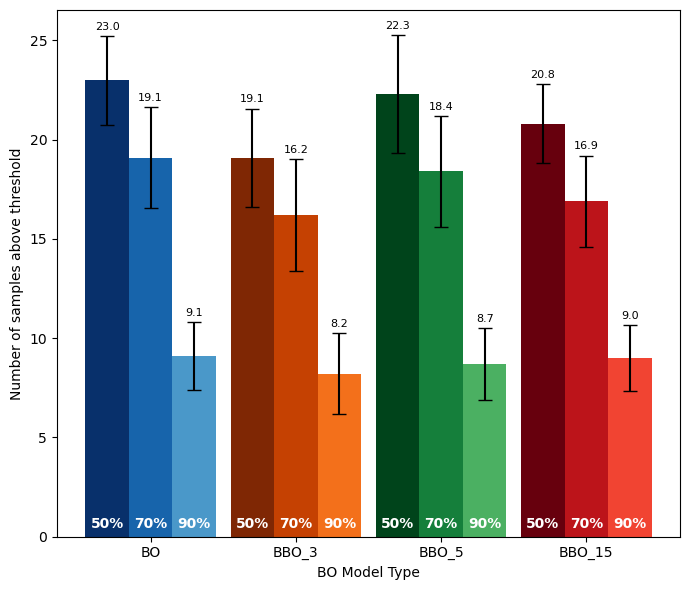

In [110]:
# Assuming idsBO_all, idsBBO_3_all, idsBBO_5_all, idsBBO_15_all are already computed
labels = ['BO', 'BBO_3', 'BBO_5', 'BBO_15']
thresholds = [0.5, 0.7, 0.9]
cmap_dict = {'BO': cm.Blues, 'BBO_3': cm.Oranges, 'BBO_5': cm.Greens, 'BBO_15': cm.Reds}

# Prepare counts per model per threshold
model_counts = []
for model_dict in [idsBO_all, idsBBO_3_all, idsBBO_5_all, idsBBO_15_all]:
    model_counts.append([model_dict[thresh].mean() for thresh in thresholds])

num_models = len(labels)
num_thresholds = len(thresholds)
bar_width = 0.3
x = np.arange(num_models)  # positions for BO, BBO_3, BBO_5, BBO_15

fig, ax = plt.subplots(figsize=(7, 6))

for j, thresh in enumerate(thresholds):
    means = [
        idsBO_all[thresh].mean(),
        idsBBO_3_all[thresh].mean(),
        idsBBO_5_all[thresh].mean(),
        idsBBO_15_all[thresh].mean()
    ]
    stds = [
        idsBO_all[thresh].std(),
        idsBBO_3_all[thresh].std(),
        idsBBO_5_all[thresh].std(),
        idsBBO_15_all[thresh].std()
    ]

    # Shift bars sideways for each threshold group
    xpos = x + (j - 1) * bar_width  # center at group, j=0 left, j=1 center, j=2 right

    for i, model in enumerate(labels):
        cmap = cmap_dict[model]
        color = cmap(0.6 + 0.4 * (1 - j / (num_thresholds - 1)))  # lighter for higher thresholds
        rect = ax.bar(xpos[i], means[i], width=bar_width, color=color,
                      yerr=stds[i], capsize=5,
                      label=f'Threshold {thresholds[j]:.1f}' if i == 0 else None)
        ax.bar_label(rect, padding=3, fontsize=8, fmt='%.1f')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Number of samples above threshold')
ax.set_xlabel('BO Model Type')
plt.tight_layout()

# Add annotations for thresholds
for i, model in enumerate(labels):
    for j, count in enumerate(model_counts[i]):
        xpos = x[i] + j * bar_width - bar_width  # Center group around x[i]
        ax.text(xpos, 0.3, f'{thresholds[j]*100:.0f}%', ha='center', va='bottom', fontsize=10, fontweight = 'bold',color='white')

plt.show()


In [49]:
y_best_1_all = []
y_best_3_all = []
y_best_5_all = []
y_best_15_all = []
varsum_1_all = []
varsum_3_all = []
varsum_5_all = []
varsum_15_all = []

for result in results_store:
    y_best_1 = (result[1]['y_best'].flatten())
    y_best_3 = (result[3]['y_best'].flatten() )
    y_best_5 = (result[5]['y_best'].flatten() )
    y_best_15 = (result[15]['y_best'] .flatten())

    varsum_1 = (np.array(result[1]['varsum']))
    varsum_3 = (np.array(result[3]['varsum']))
    varsum_5 = (np.array(result[5]['varsum']))
    varsum_15 = (np.array(result[15]['varsum']))

    y_best_1_all.append(y_best_1)
    y_best_3_all.append(y_best_3)
    y_best_5_all.append(y_best_5)
    y_best_15_all.append(y_best_15)

    varsum_1_all.append(varsum_1)
    varsum_3_all.append(varsum_3)
    varsum_5_all.append(varsum_5)
    varsum_15_all.append(varsum_15)

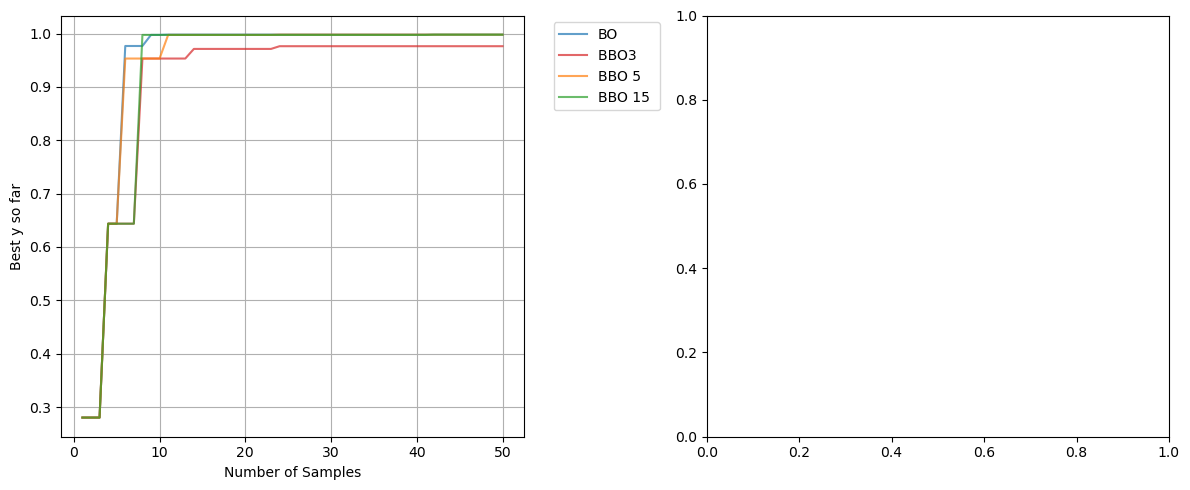

In [111]:
# Plot number of samples vs best y for BO, BO_batch, BBO, and BO_q1

# Prepare data
labels = ['BO', 'BBO3 ', 'BBO 5', 'BBO 15 ']
colors = ['tab:blue', 'tab:red', 'tab:orange', 'tab:green']
n = 3
y_lists = [
    np.array(results_store[n][1]['y_best']),
    np.array(results_store[n][3]['y_best']),
    np.array(results_store[n][5]['y_best']),
    np.array(results_store[n][15]['y_best'])
]


varsum_lists = [
    np.array(varsum_1_all),
    np.array(varsum_3_all),
    np.array(varsum_5_all),
    np.array(varsum_15_all)
]
varsum_lists_std = [
    np.array(varsum_1_all).std(axis=0),
    np.array(varsum_3_all).std(axis=0),
    np.array(varsum_5_all).std(axis=0),
    np.array(varsum_15_all).std(axis=0)
]
sample_counts = [np.arange(1, len(y) + 1) for y in y_lists]
best_y = [np.maximum.accumulate(y) for y in y_lists]
varsum = [np.maximum.accumulate(var) for var in varsum_lists]
iterations = [np.arange(1, len(var) + 1) for var in varsum_lists]
# Plot as a 1x2 subplot: (left) Best y vs Number of Samples, (right) All y values vs Number of Samples

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Best y so far
for samples, best, label, color in zip(sample_counts, best_y, labels, colors):
    axes[0].plot(samples, best, label=label, marker='', alpha=0.7, color=color)
axes[0].set_xlabel('Number of Samples')
axes[0].set_ylabel('Best y so far')
# axes[0].set_title('Best y vs Number of Samples')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
axes[0].grid(True)

# # Right: All y values (not just best-so-far)
# for iter, varsum,std, label in zip(iterations , varsum_lists,varsum_lists_std, labels):
#     axes[1].plot(iter, varsum, label=label, marker='.', alpha=0.7)
# axes[1].set_xlabel('Number of Samples')
# axes[1].set_ylabel('y')
# axes[1].set_title('All y values vs Number of Samples')
# axes[1].legend()
# axes[1].grid(True)

plt.tight_layout()
plt.show()

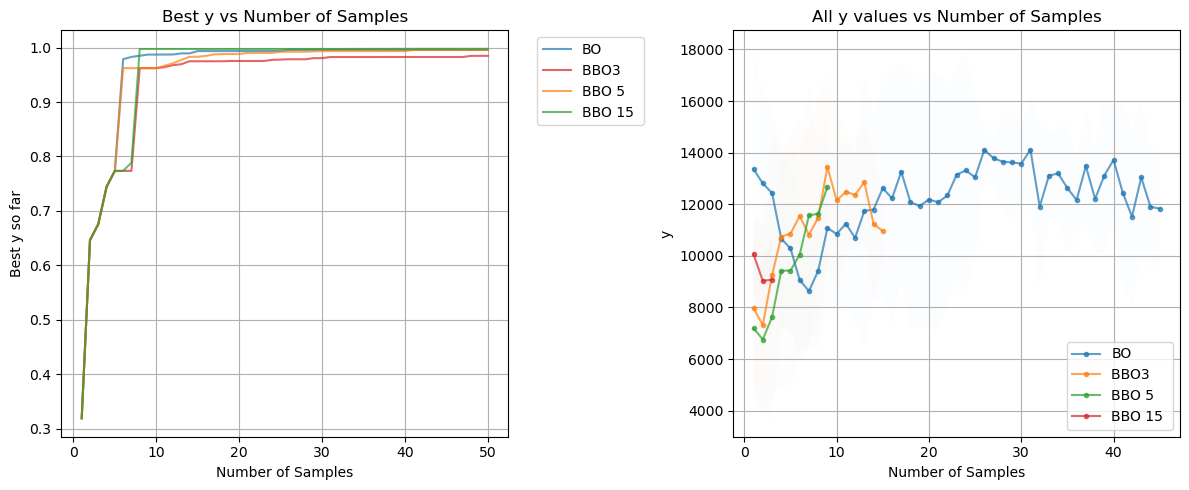

In [94]:
# Plot number of samples vs best y for BO, BO_batch, BBO, and BO_q1
lables = ['BO', 'BBO3', 'BBO5', 'BBO15']
hatches = ['\\', '//', '+++', 'xxx']
colors = ['tab:blue', 'tab:red', 'tab:orange', 'tab:green']
# Prepare data
y1_all = np.array([np.maximum.accumulate(y) for y in y_best_1_all])
y3_all = np.array([np.maximum.accumulate(y) for y in y_best_3_all])
y5_all = np.array([np.maximum.accumulate(y) for y in y_best_5_all])
y15_all= np.array([np.maximum.accumulate(y) for y in y_best_15_all])

y_lists = [y1_all.mean(axis=0), y3_all.mean(axis=0), y5_all.mean(axis=0), y15_all.mean(axis=0)]
y_list_std = [y1_all.std(axis=0), y3_all.std(axis=0), y5_all.std(axis=0), y15_all.std(axis=0)]


varsum_lists = [
    np.array(varsum_1_all).mean(axis=0),
    np.array(varsum_3_all).mean(axis=0),
    np.array(varsum_5_all).mean(axis=0),
    np.array(varsum_15_all).mean(axis=0)
]
varsum_lists_std = [
    np.array(varsum_1_all).std(axis=0),
    np.array(varsum_3_all).std(axis=0),
    np.array(varsum_5_all).std(axis=0),
    np.array(varsum_15_all).std(axis=0)
]
sample_counts = [np.arange(1, len(y) + 1) for y in y1_all]
varsum = [np.maximum.accumulate(var) for var in varsum_lists]
iterations = [np.arange(1, len(var) + 1) for var in varsum_lists]
# Plot as a 1x2 subplot: (left) Best y vs Number of Samples, (right) All y values vs Number of Samples

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Best y so far
for samples, best, y_std, label, hatch, color in zip(sample_counts, y_lists, y_list_std,labels, hatches, colors):
    axes[0].plot(samples, best, label=label, marker='', alpha=0.7, color=color)
    # Cap the fill region to be at most 1
    # lower = np.maximum(best - y_std,0)
    # upper = np.minimum(best + y_std, 1)
    #axes[0].fill_between(samples, lower, upper, alpha=0.2)
    #axes[0].fill_between(samples, np.array(best) - np.array(y_std), np.array(best) + np.array(y_std), alpha=0.05, hatch = hatch,edgecolor=color)
axes[0].set_xlabel('Number of Samples')
axes[0].set_ylabel('Best y so far')
axes[0].set_title('Best y vs Number of Samples')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
axes[0].grid(True)

# Right: All y values (not just best-so-far)
for iter, varsum,std, label in zip(iterations , varsum_lists,varsum_lists_std, labels):
    axes[1].plot(iter, varsum, label=label, marker='.', alpha=0.7)
    axes[1].fill_between(iter, np.array(varsum) - np.array(std), np.array(varsum) + np.array(std), alpha=0.01)
axes[1].set_xlabel('Number of Samples')
axes[1].set_ylabel('y')
axes[1].set_title('All y values vs Number of Samples')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def BO_batch_loop(gp_model,train_nx, train_y,train_yvar, x_all, y_all, yvar_all,iterations=5):
    query = PoolObjectives(x_all, y_all, yvar_all, columns=['time', 'temp', 'sulf', 'anly'])
    progress = tqdm(total=iterations, desc="BO Iterations", leave=True)  # put progress bar here
    
    for i in range(iterations):
        # Step 3: Get the next candidates
        
        # Remove new_candidates from x_all
        x_actual, y_actual, yvar_actual, used_id = gp_model.regular_candidates(x_all, batch_size=5)
        #print(used_id)
        x_all = query.get_new_pool(used_id)

        nx_train = normalize(x_actual, bounds=original_bounds)
        #print(x_train.shape, y_train.shape, yvar_train.shape)
        # Combine the new data with the existing data
        train_nx = torch.cat((train_nx, nx_train), dim=0)
        train_y = torch.cat((train_y, y_actual), dim=0)
        train_yvar = torch.cat((train_yvar, yvar_actual), dim=0)
        #print(train_nx.shape, train_y.shape, train_yvar.shape)
        # Step 1: Instantiate and train model
        gp_model = Models(x_train=train_nx, y_train=train_y, y_train_var=train_yvar, bounds=original_bounds, batch_size=batch_size, objective=query, random_id = random_seed)
        progress.update(1)  # update after each iteration

    progress.close()
    return gp_model, train_nx, train_y, train_yvar


BO Iterations:   0%|          | 0/9 [00:00<?, ?it/s]

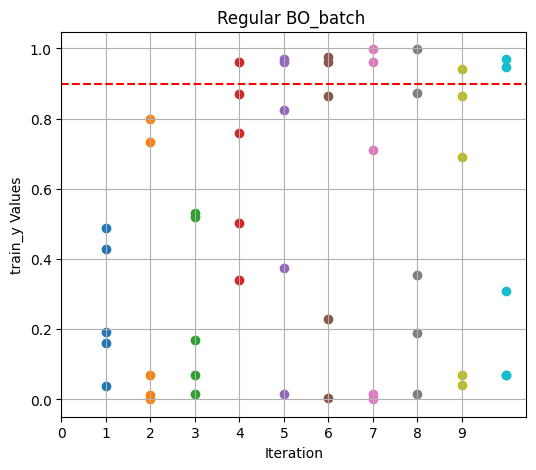

Iteration 1: tensor([198., 148.,  85., 100.])
Iteration 2: tensor([163., 145.,  90.,  57.])
Iteration 3: tensor([468., 104.,  85.,  54.])
Iteration 4: tensor([556., 133.,  89.,  46.])
Iteration 5: tensor([569., 137.,  99.,  65.])
Iteration 6: tensor([372., 133.,  96.,  41.])
Iteration 7: tensor([391., 145.,  97.,  35.])
Iteration 8: tensor([353., 145.,  94.,  66.])
Iteration 9: tensor([561., 133.,  87.,  67.])
Iteration 10: tensor([569., 137.,  99.,  65.])


In [ ]:
# Reset 
x_inputs = all_data[['time','temp','sulf','anly'] ]
y_outputs = all_data["yield product"]
yvar_outputs = all_data["var yield"]

iterations = 9
batch_size = 5
gp_modelBO_batch, train_nxBO_batch, train_yBO_batch, train_yvarBO_batch = BO_batch_loop(gp_model, nx_train, y_train, y_train_var, x_input_new, y_output_new ,yvar_output_new, iterations = iterations)

train_xBO_batch = unnormalize(train_nxBO_batch, original_bounds)
# Step 2: Initialize Plotting class
variable_combinations = [('time', 'sulf', 'anly'), ('theta', 'r', 't'), ('n', 't', 'theta')]
plotting = Plotting(gp_modelBO_batch, variable_combinations=variable_combinations, select='Gaussian')

combination = variable_combinations[0]

minmax = [y_train.min(), y_train.max()]
# plotting.sliced_plotting('ModelC',combination, minmax)


points_per_iteration = 5
split_data = [train_yBO_batch[:batch_size]] + [
    train_yBO_batch[batch_size:][i * points_per_iteration:(i + 1) * points_per_iteration]
    for i in range(iterations)
]

split_datax = [train_xBO_batch[:batch_size]] + [
    train_xBO_batch[batch_size:][i * points_per_iteration:(i + 1) * points_per_iteration]
    for i in range(iterations)
]

# Plot the points vertically
plt.figure(figsize=(6, 5))
for i, data in enumerate(split_data):
    plt.scatter([i + 1] * len(data), data.numpy(), label=f'Iteration {i + 1}')

plt.xlabel('Iteration')
plt.ylabel('train_y Values')
plt.title('Regular BO_batch ')
plt.xticks(range(0, iterations + 1))
plt.axhline(y=0.9, color='red', linestyle='--', label='y=0.9')
# plt.legend()
plt.grid(True)
plt.show()

argmax_indices = [data.argmax().item() for data in split_data]
for i, idx in enumerate(argmax_indices):
    print(f"Iteration {i + 1}: {split_datax[i][idx]}")

